In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

In [2]:
# Path to dataset
path = 'E:\\python\\code\\trafficSignClassification\\dataset'
lab = pd.read_csv(os.path.join(path, 'labels.csv'))

C:\Users\12911\AppData\Local\Temp\ipykernel_2144\2598212653.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=list(d.keys()), x=list(d.values()), palette='Set3')


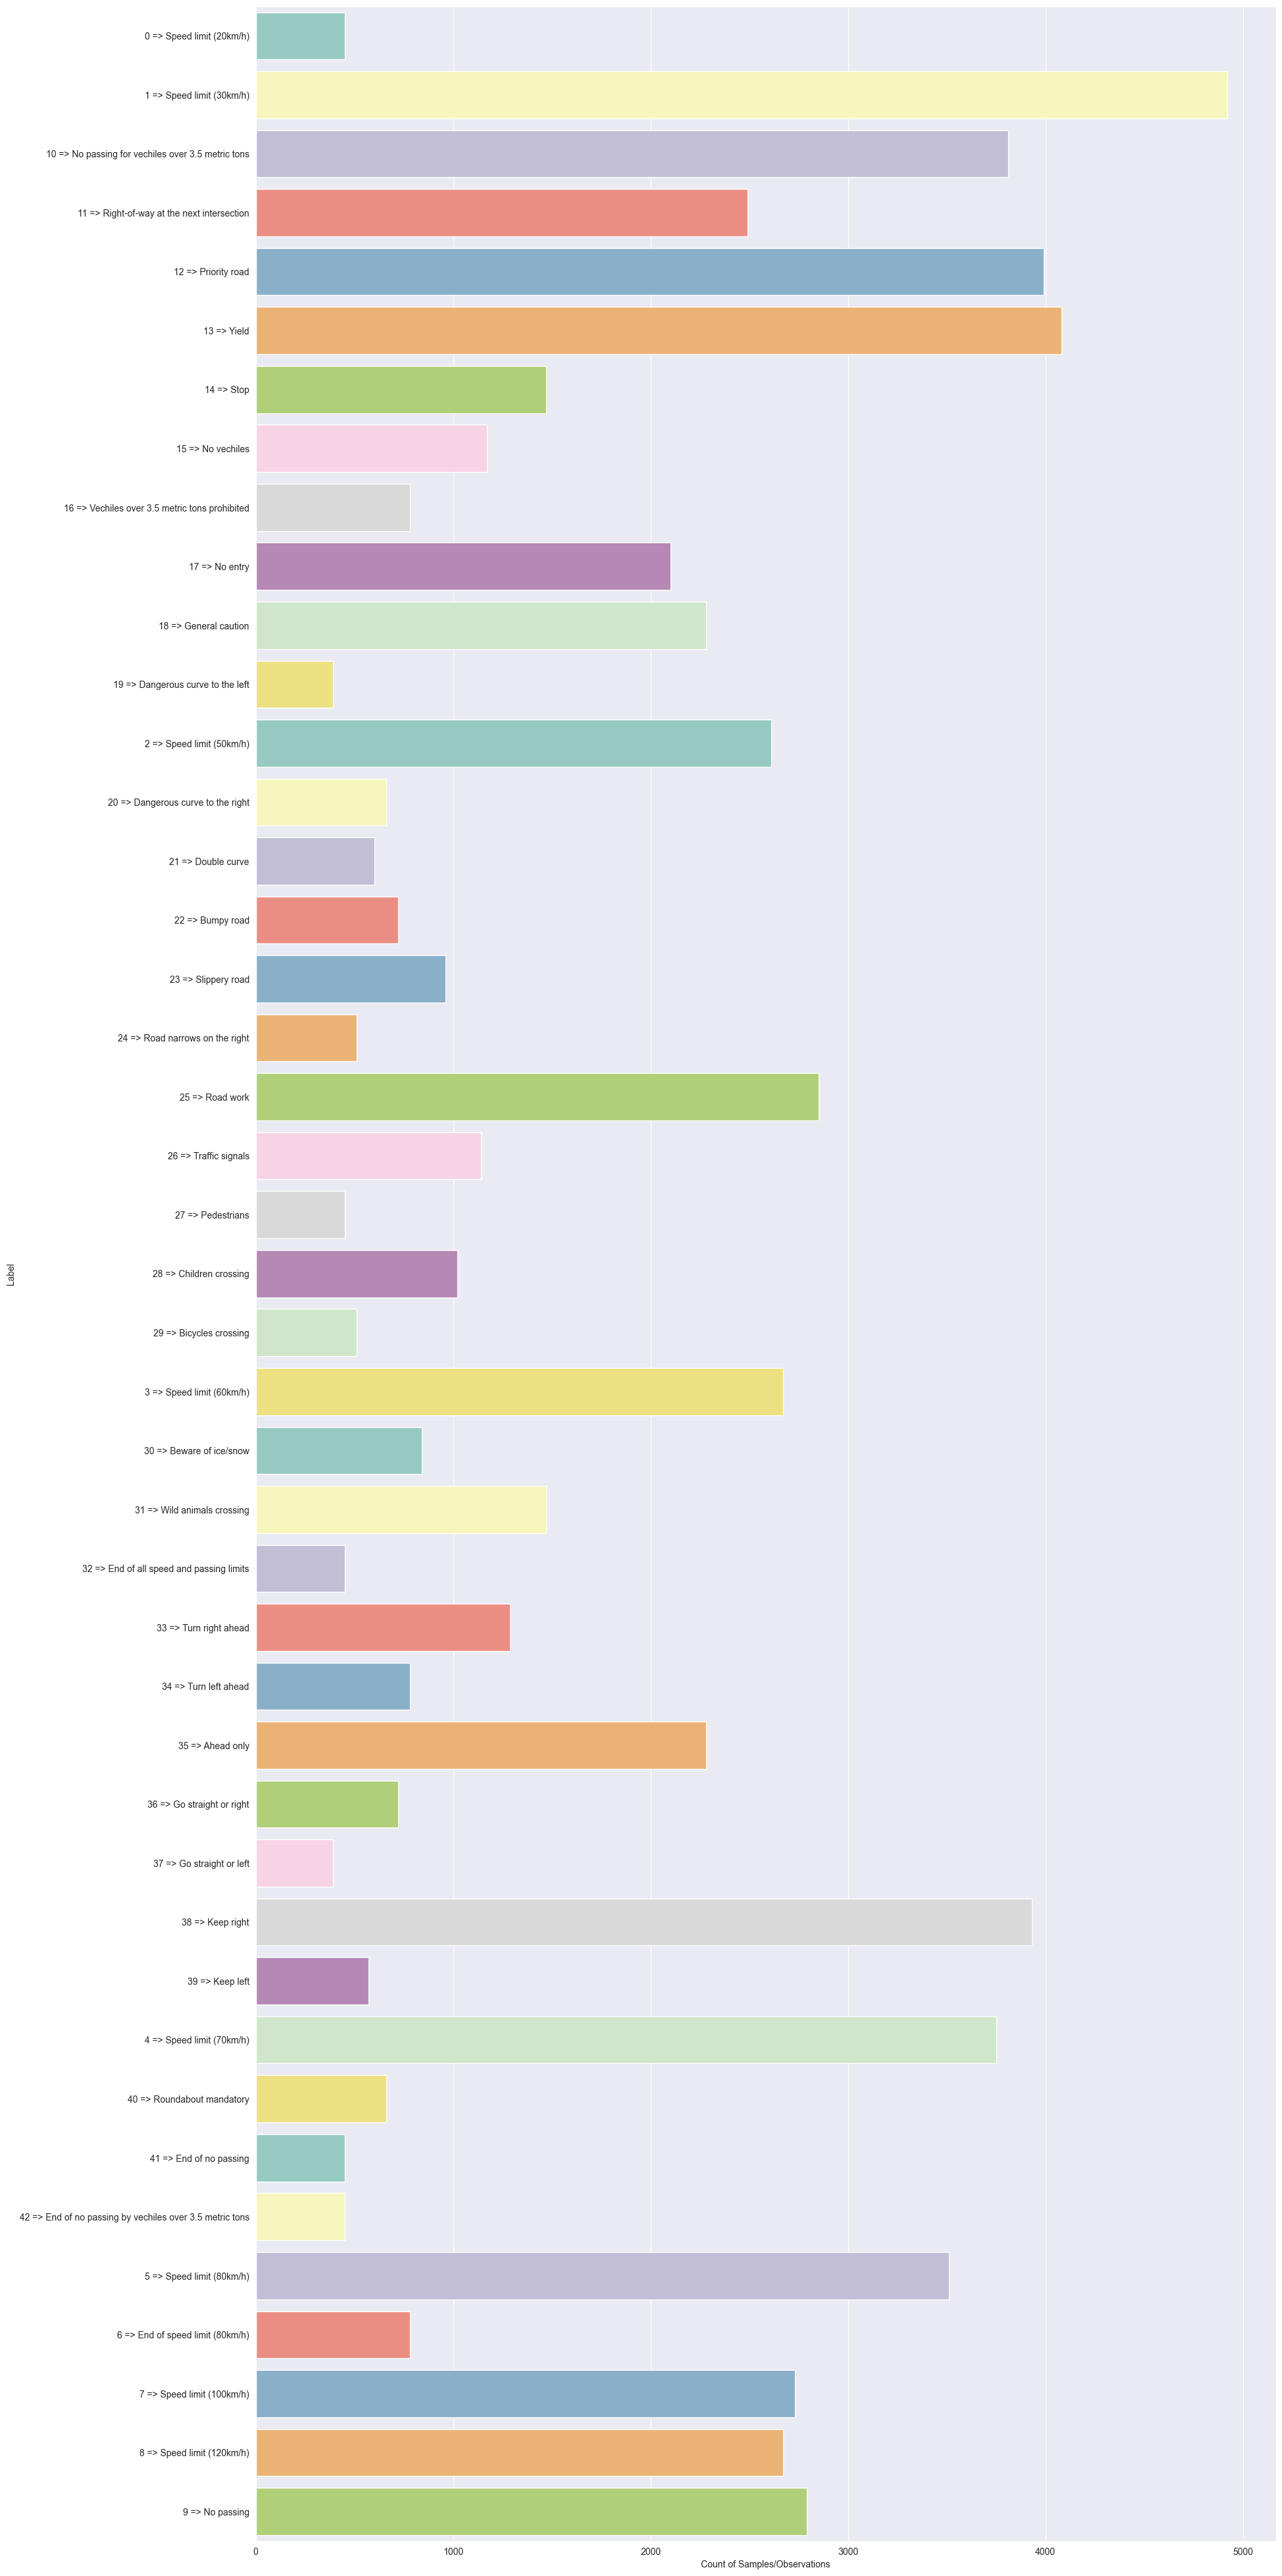

In [3]:
# Prepare class labels
# '0 => Speed limit (20km/h)': 451
d = dict()
# 0: 'Speed limit (20km/h)'
class_labels = dict()
for dirs in os.listdir(os.path.join(path, 'myData')):
    count = len(os.listdir(os.path.join(path, 'myData', dirs)))
    d[dirs + ' => ' + lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize=(20, 50))
sns.barplot(y=list(d.keys()), x=list(d.values()), palette='Set3')
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations')
plt.show()

In [4]:
# Input image dimensions
img_rows, img_cols = 32, 32
img_channels = 3
nb_classes = len(class_labels.keys())

In [5]:
# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((img_rows, img_cols)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)  # Normalize images to [-1, 1]
])

In [6]:
# Dataset and DataLoader
dataset = ImageFolder(os.path.join(path, 'myData'), transform=data_transforms)
# Split dataset into train, validation, and test sets
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Step 1: Split into train and temp datasets
train_indices, temp_indices = train_test_split(
    range(len(dataset)),
    test_size=1 - train_size,
    random_state=42,
    stratify=[dataset.targets[i] for i in range(len(dataset))]
)

# Step 2: Split temp dataset into validation and test datasets
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=test_size / (test_size + val_size),
    random_state=42,
    stratify=[dataset.targets[i] for i in temp_indices]
)

# Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

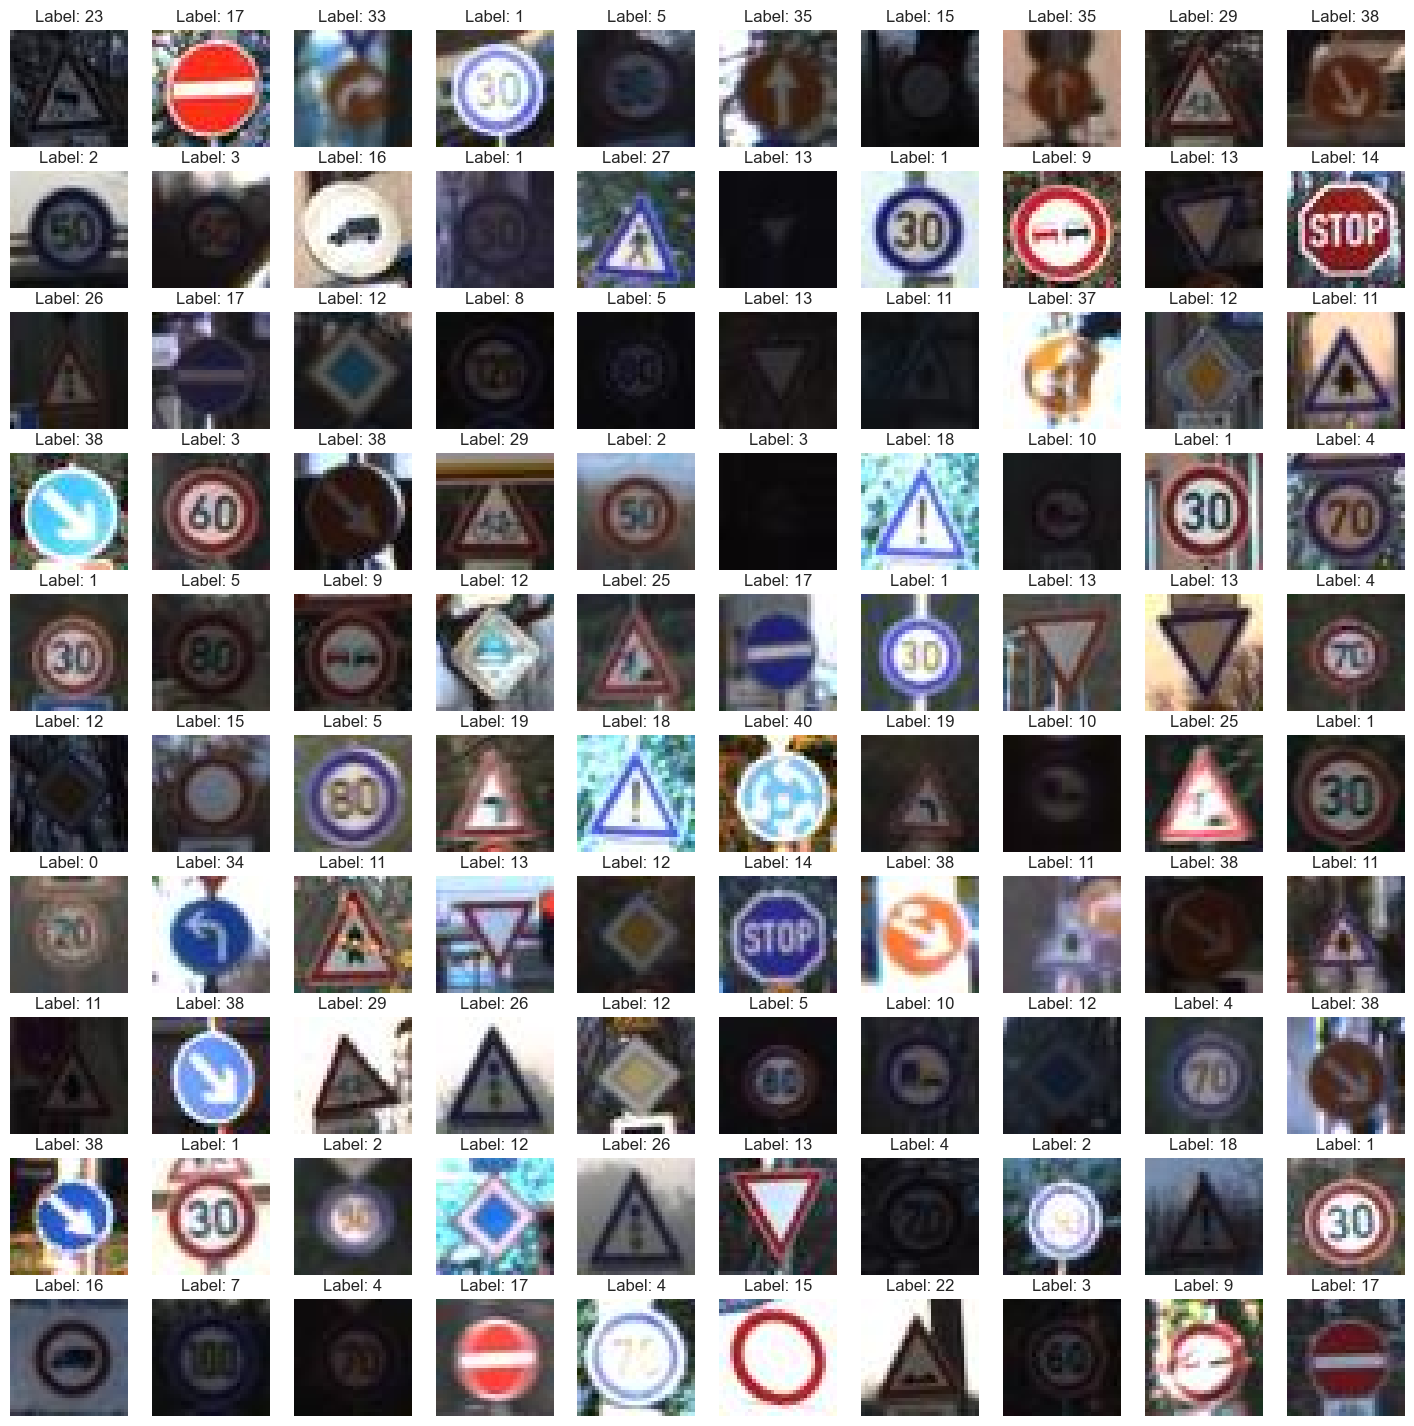

In [7]:
# Visualize sample images
fig, axes = plt.subplots(10, 10, figsize=(18, 18))
for i, ax in enumerate(axes.flat):
    r = np.random.randint(len(dataset))
    img, label = dataset[r]
    ax.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Denormalize
    ax.grid(False)
    ax.axis('off')
    ax.set_title(f'Label: {dataset.classes[label]}')
plt.show()

In [8]:
# Define model using ResNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pretrained=False表示加载未经预训练的模型
model = models.resnet50(pretrained=False)
# model.fc.in_features获取全连接层输入特征的大小
model.fc = nn.Linear(model.fc.in_features, nb_classes)  # Adjust output layer for nb_classes
model = model.to(device)

E:\Anaconda\envs\trafficSignClassification\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\envs\trafficSignClassification\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# # optimizer = optim.RMSprop(model.parameters(), lr=0.001)
# optimizer = optim.Adagrad(model.parameters(), lr=0.001)

Epoch 1/20, Train Loss: 2.2353, Train Acc: 0.4462, Val Loss: 1.2409, Val Acc: 0.6346
Epoch 2/20, Train Loss: 1.0198, Train Acc: 0.7193, Val Loss: 1.1519, Val Acc: 0.6829
Epoch 3/20, Train Loss: 0.5616, Train Acc: 0.8361, Val Loss: 0.5409, Val Acc: 0.8404
Epoch 4/20, Train Loss: 0.2666, Train Acc: 0.9225, Val Loss: 0.1434, Val Acc: 0.9544
Epoch 5/20, Train Loss: 0.2025, Train Acc: 0.9431, Val Loss: 0.1171, Val Acc: 0.9617
Epoch 6/20, Train Loss: 0.1487, Train Acc: 0.9569, Val Loss: 0.2375, Val Acc: 0.9301
Epoch 7/20, Train Loss: 0.1103, Train Acc: 0.9680, Val Loss: 0.1422, Val Acc: 0.9550
Epoch 8/20, Train Loss: 0.1034, Train Acc: 0.9699, Val Loss: 0.0547, Val Acc: 0.9834
Epoch 9/20, Train Loss: 0.0741, Train Acc: 0.9785, Val Loss: 0.1775, Val Acc: 0.9461
Epoch 10/20, Train Loss: 0.1009, Train Acc: 0.9724, Val Loss: 0.0394, Val Acc: 0.9885
Epoch 11/20, Train Loss: 0.0486, Train Acc: 0.9854, Val Loss: 0.0415, Val Acc: 0.9891
Epoch 12/20, Train Loss: 0.0454, Train Acc: 0.9871, Val Loss: 0

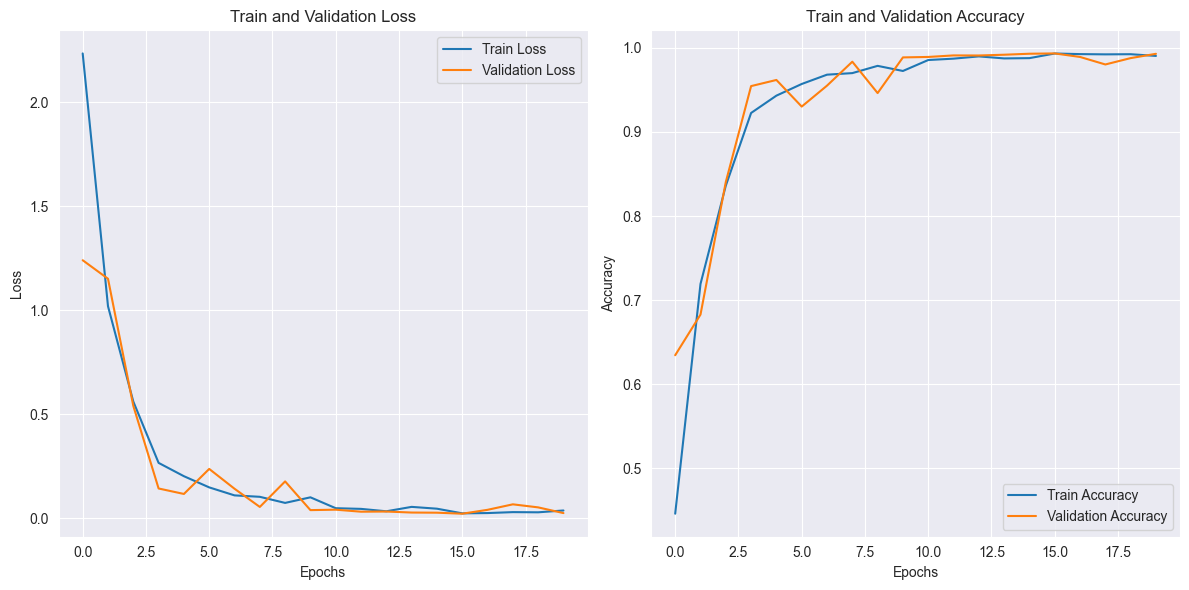

In [10]:
# Training loop
n_epochs = 20
best_accuracy = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(n_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (torch.argmax(outputs, 1) == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_corrects / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += (torch.argmax(outputs, 1) == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects / len(val_loader.dataset)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

def plot_history(history):
    # 绘制训练和验证损失
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')

    # 绘制训练和验证准确率
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train and Validation Accuracy')

    plt.tight_layout()
    plt.show()

# 绘制训练过程
plot_history(history)

In [11]:
# Evaluate the model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

C:\Users\12911\AppData\Local\Temp\ipykernel_2144\2162694277.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      0.97      0.98        67
                              Speed limit (30km/h)       0.99      1.00      1.00       738
                              Speed limit (50km/h)       1.00      1.00      1.00       571
                              Speed limit (60km/h)       0.99      1.00      0.99       373
                              Speed limit (70km/h)       0.99      1.00      1.00       599
                              Speed limit (80km/h)       1.00      1.00      1.00       612
                       End of speed limit (80km/h)       1.00      1.00      1.00       221
                             Speed limit (100km/h)       0.99      0.99      0.99       175
                             Speed limit (120km/h)       1.00      1.00      1.00       117
                                        No passing       1.00      1.00      1.

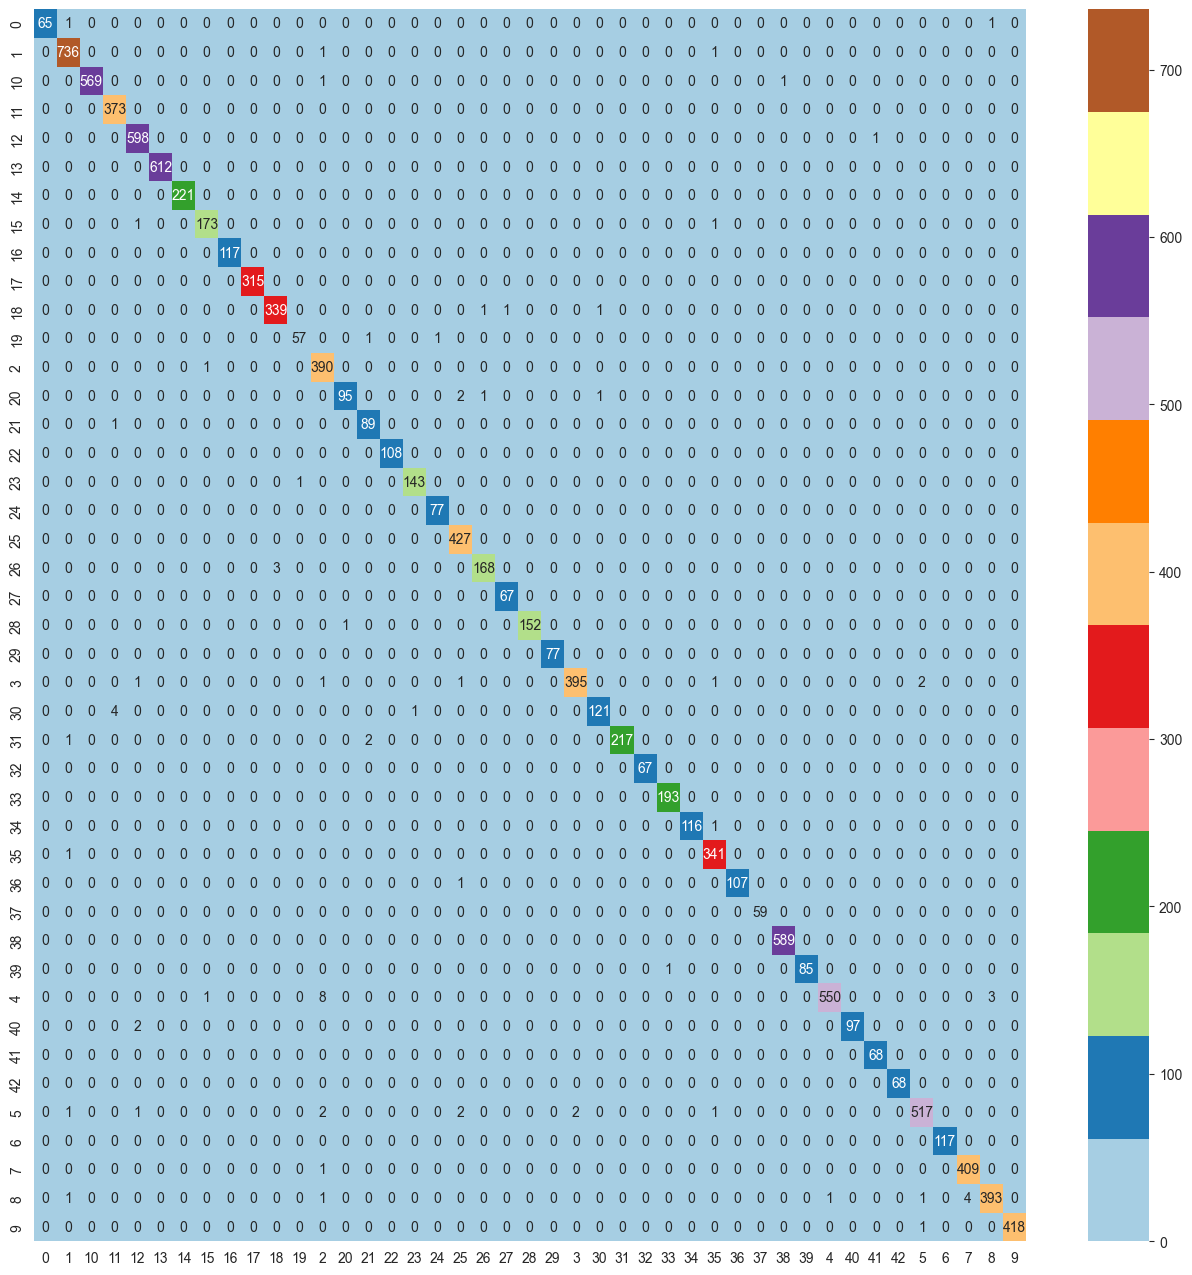

In [12]:
# Classification report and confusion matrix
print(classification_report(y_true, y_pred, target_names=[class_labels[i] for i in range(nb_classes)]))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap='Paired', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.show()

In [13]:
classwise_acc = cm.diagonal() / cm.sum(axis=1)
cls_acc = pd.DataFrame({'Class_Label': [class_labels[i] for i in range(nb_classes)],
                        'Accuracy': classwise_acc * 100})

total_acc = cm.diagonal().sum() / cm.sum()
cls_acc.loc[len(cls_acc)] = ['Total Accuracy', total_acc * 100]

print(cls_acc)

                                          Class_Label    Accuracy
0                                Speed limit (20km/h)   97.014925
1                                Speed limit (30km/h)   99.728997
2                                Speed limit (50km/h)   99.649737
3                                Speed limit (60km/h)  100.000000
4                                Speed limit (70km/h)   99.833055
5                                Speed limit (80km/h)  100.000000
6                         End of speed limit (80km/h)  100.000000
7                               Speed limit (100km/h)   98.857143
8                               Speed limit (120km/h)  100.000000
9                                          No passing  100.000000
10       No passing for vechiles over 3.5 metric tons   99.122807
11              Right-of-way at the next intersection   96.610169
12                                      Priority road   99.744246
13                                              Yield   95.959596
14        

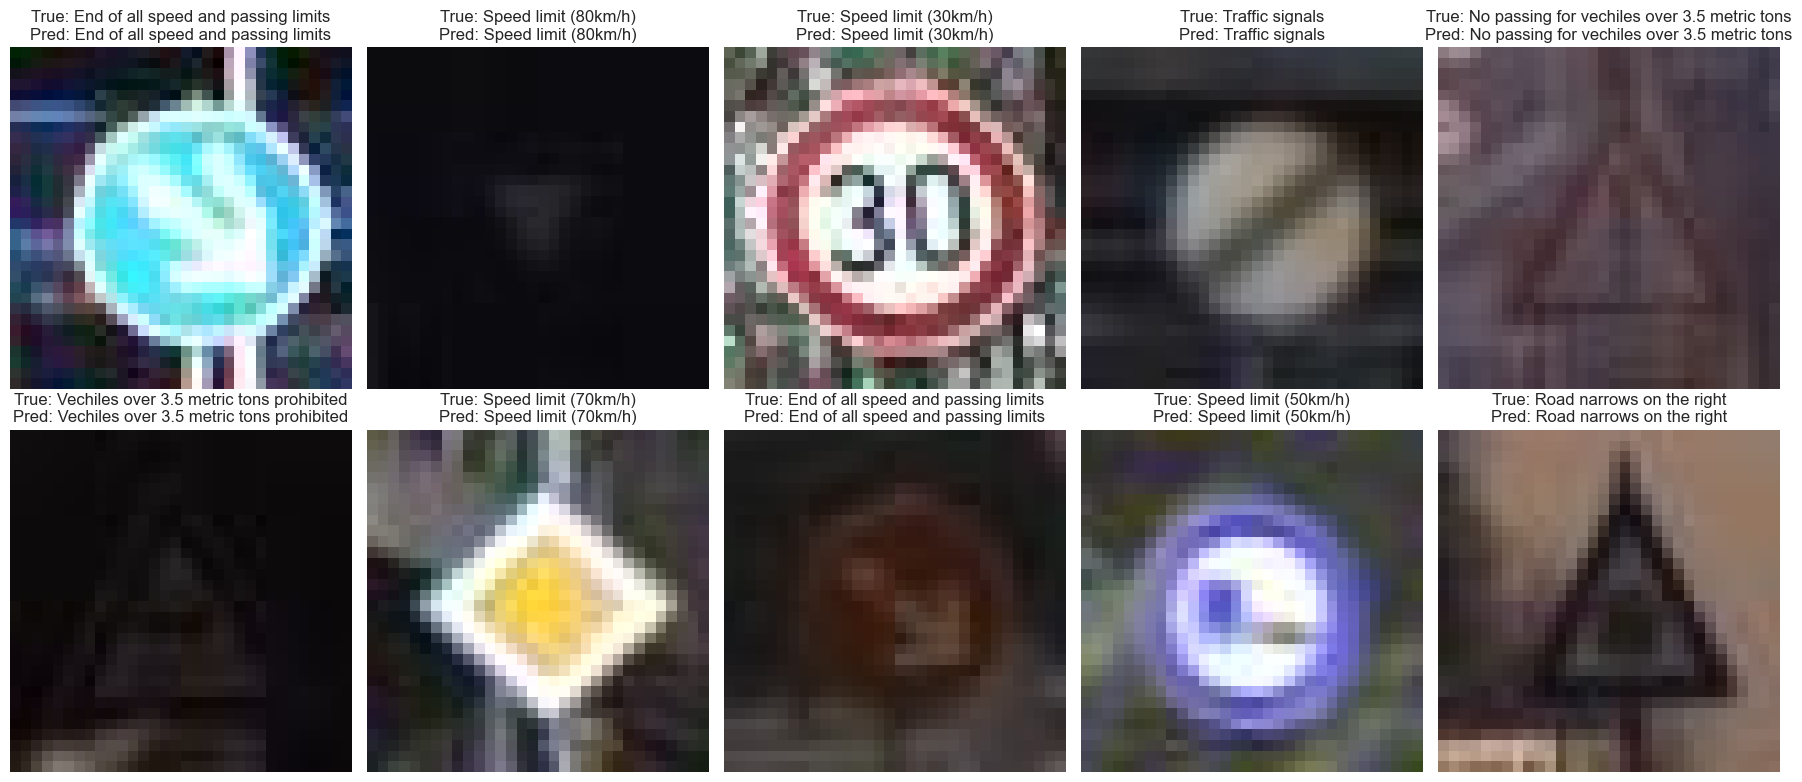

In [17]:
# Visualize sample images with predictions
fig, axes = plt.subplots(2, 5, figsize=(18, 8))  # 创建2行5列的网格
model.eval()  
for i, ax in enumerate(axes.flat):
    r = np.random.randint(len(test_dataset))
    img, true_label = test_dataset[r]
    
    with torch.no_grad():
        img_tensor = img.unsqueeze(0).to(device) 
        pred = model(img_tensor).argmax(dim=1).item()  

    ax.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  
    ax.grid(False)
    ax.axis('off')
    
    ax.set_title(f'True: {class_labels[true_label]}\nPred: {class_labels[pred]}', fontsize=12)

plt.tight_layout()
plt.show()
